In [27]:
import jax
import jax.numpy as jnp
from functools import partial
import matplotlib.pyplot as plt
import trimesh

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = jnp.array(vertices, dtype=jnp.float32)  # Shape: (V, 3)
        self.faces = jnp.array(faces, dtype=jnp.int32)          # Shape: (F, 3)

@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    epsilon = 1e-6
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = 1.0 / a
    s = p0 - v0
    u = f * jnp.dot(s, h)
    valid_u = (u >= 0.0) & (u <= 1.0)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    valid_v = (v >= 0.0) & (u + v <= 1.0)
    t = f * jnp.dot(e2, q)
    valid_t = t > epsilon
    intersects = (~parallel) & valid_u & valid_v & valid_t
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])  # Arbitrary direction
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    
    intersects = jax.vmap(
        ray_intersects_triangle, in_axes=(None, None, 0, 0, 0)
    )(point, ray_direction, v0, v1, v2)
    num_intersections = jnp.sum(intersects)
    return num_intersections % 2 == 1  # Inside if odd number of intersections

def min_max_coord(vertices):
    min_coords = jnp.min(vertices, axis=0)
    max_coords = jnp.max(vertices, axis=0)
    return min_coords, max_coords

@partial(jax.jit, static_argnames=['num_samples'])
def monte_carlo_intersection_volume(
    mesh1_vertices, mesh1_faces, mesh2_vertices, mesh2_faces, num_samples, key
):
    min_coords1, max_coords1 = min_max_coord(mesh1_vertices)
    min_coords2, max_coords2 = min_max_coord(mesh2_vertices)
    
    min_coords = jnp.maximum(min_coords1, min_coords2)
    max_coords = jnp.minimum(max_coords1, max_coords2)
    
    overlap = jnp.all(min_coords < max_coords)
    bbox_volume = jnp.prod(max_coords - min_coords)
    
    def sample_points(key):
        subkey_x, subkey_y, subkey_z = jax.random.split(key, 3)
        x = jax.random.uniform(subkey_x, shape=(num_samples,), minval=min_coords[0], maxval=max_coords[0])
        y = jax.random.uniform(subkey_y, shape=(num_samples,), minval=min_coords[1], maxval=max_coords[1])
        z = jax.random.uniform(subkey_z, shape=(num_samples,), minval=min_coords[2], maxval=max_coords[2])
        points = jnp.stack([x, y, z], axis=1)
        return points
    
    points = sample_points(key)
    
    point_in_mesh_vmap = jax.vmap(point_in_mesh, in_axes=(0, None, None))
    
    in_mesh1 = point_in_mesh_vmap(points, mesh1_vertices, mesh1_faces)
    in_mesh2 = point_in_mesh_vmap(points, mesh2_vertices, mesh2_faces)
    in_both_meshes = in_mesh1 & in_mesh2
    
    hits = jnp.sum(in_both_meshes)
    intersection_volume = (hits / num_samples) * bbox_volume * overlap
    return intersection_volume



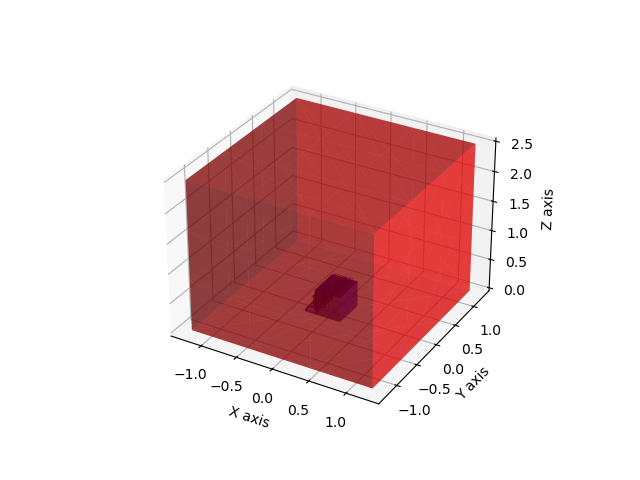

In [28]:
%matplotlib widget
# Plot the two meshes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mesh1 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/all/coffee_maker.obj')
ax.plot_trisurf(mesh1.vertices[:, 0], mesh1.vertices[:,2], mesh1.vertices[:,1], triangles=mesh1.faces, 
                    color='b', alpha=0.5)
 
mesh2 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/all/cube.obj')
mesh2.vertices *= 2.5
ax.plot_trisurf(mesh2.vertices[:, 0], mesh2.vertices[:,2], mesh2.vertices[:,1], triangles=mesh2.faces, 
                    color='r', alpha=0.5)

# Set plot limits and labels
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_zlim(0, 2)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [29]:
num_samples = 1000  # Adjust for desired accuracy
key = jax.random.PRNGKey(0)  # Random seed

intersection_volume = monte_carlo_intersection_volume(
    mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces, num_samples, key
)
print("Intersection Volume (Monte Carlo with JAX):", intersection_volume)


Intersection Volume (Monte Carlo with JAX): 0.09196061


In [30]:
mesh1.volume

0.094357025588184

## memory-efficient implementation

In [31]:
import jax
import jax.numpy as jnp
from jax import random, lax

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = jnp.array(vertices, dtype=jnp.float32)  # Shape: (V, 3)
        self.faces = jnp.array(faces, dtype=jnp.int32)          # Shape: (F, 3)

@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    epsilon = 1e-8
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = jnp.where(~parallel, 1.0 / a, 0.0)
    s = p0 - v0
    u = f * jnp.dot(s, h)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    t = f * jnp.dot(e2, q)
    intersects = (~parallel) & (u >= 0.0) & (v >= 0.0) & (u + v <= 1.0) & (t > epsilon)
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]

    def intersect_triangle(carry, i):
        intersects = ray_intersects_triangle(point, ray_direction, v0[i], v1[i], v2[i])
        count = carry + intersects
        return count, None

    num_faces = faces.shape[0]
    total_intersections, _ = lax.scan(intersect_triangle, 0, jnp.arange(num_faces))
    inside = total_intersections % 2 == 1
    return inside

@jax.jit
def process_batch(batch_points, mesh1_vertices, mesh1_faces, mesh2_vertices, mesh2_faces):
    in_mesh1 = jax.vmap(point_in_mesh, in_axes=(0, None, None))(batch_points, mesh1_vertices, mesh1_faces)
    in_mesh2 = jax.vmap(point_in_mesh, in_axes=(0, None, None))(batch_points, mesh2_vertices, mesh2_faces)
    in_both = in_mesh1 & in_mesh2
    return in_both

def monte_carlo_interpenetration_volume(mesh1, mesh2, num_samples, key, batch_size=100000):
    # Compute overlapping bounding box
    min_coords1 = jnp.min(mesh1.vertices, axis=0)
    max_coords1 = jnp.max(mesh1.vertices, axis=0)
    min_coords2 = jnp.min(mesh2.vertices, axis=0)
    max_coords2 = jnp.max(mesh2.vertices, axis=0)

    min_coords = jnp.maximum(min_coords1, min_coords2)
    max_coords = jnp.minimum(max_coords1, max_coords2)

    # Check if bounding boxes overlap
    overlap = jnp.all(min_coords < max_coords)
    bbox_volume = jnp.prod(max_coords - min_coords)
    bbox_volume = jnp.where(overlap, bbox_volume, 0.0)

    if not overlap:
        return 0.0  # No overlap

    # Generate all random points upfront
    num_full_batches = num_samples // batch_size
    remainder = num_samples % batch_size
    total_batches = num_full_batches + (1 if remainder > 0 else 0)

    # Generate random keys for each batch
    keys = random.split(key, num=total_batches)

    # Generate all random points
    points_list = []
    for i in range(num_full_batches):
        subkey = keys[i]
        points = random.uniform(
            subkey, shape=(batch_size, 3),
            minval=min_coords, maxval=max_coords
        )
        points_list.append(points)

    # Handle the last batch
    if remainder > 0:
        subkey = keys[-1]
        points = random.uniform(
            subkey, shape=(batch_size, 3),
            minval=min_coords, maxval=max_coords
        )
        # Mask out the extra points
        mask = jnp.arange(batch_size) < remainder
        points = points[mask]
        points_list.append(points)

    # Concatenate all points
    all_points = jnp.concatenate(points_list, axis=0)

    # Process points in batches
    num_points = all_points.shape[0]
    num_batches = (num_points + batch_size - 1) // batch_size

    total_hits = 0

    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        batch_points = all_points[start:end]

        # Pad the last batch if necessary
        if batch_points.shape[0] < batch_size:
            pad_size = batch_size - batch_points.shape[0]
            batch_points = jnp.pad(batch_points, ((0, pad_size), (0, 0)), mode='constant')

        # Perform point-in-mesh tests
        in_both = process_batch(batch_points, mesh1.vertices, mesh1.faces, mesh2.vertices, mesh2.faces)

        # For the last batch, mask out the padded points
        if i == num_batches - 1 and batch_points.shape[0] > remainder:
            mask = jnp.arange(batch_size) < (num_points - start)
            in_both = in_both & mask

        hits = jnp.sum(in_both)
        total_hits += hits

    # Estimate interpenetration volume
    interpenetration_volume = (total_hits / num_samples) * bbox_volume
    return interpenetration_volume


In [35]:
# Monte Carlo parameters
num_samples = 10000  # Increase for higher accuracy
batch_size = 100000    # Adjust based on GPU memory
key = random.PRNGKey(0)

# Compute interpenetration volume
interpenetration_volume = monte_carlo_interpenetration_volume(
    mesh1, mesh2, num_samples, key, batch_size
)

print("Interpenetration Volume:", interpenetration_volume)

Interpenetration Volume: 0.08984491


## max intersect distance

In [14]:
import jax
import jax.numpy as jnp

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = jnp.array(vertices, dtype=jnp.float32)
        self.faces = jnp.array(faces, dtype=jnp.int32)

@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    epsilon = 1e-6
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = 1.0 / a
    s = p0 - v0
    u = f * jnp.dot(s, h)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    t = f * jnp.dot(e2, q)
    intersects = (~parallel) & (u >= 0.0) & (u <= 1.0) & \
                 (v >= 0.0) & (u + v <= 1.0) & (t > epsilon)
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    intersects = jax.vmap(ray_intersects_triangle, in_axes=(None, None, 0, 0, 0))(
        point, ray_direction, v0, v1, v2)
    num_intersections = jnp.sum(intersects)
    return num_intersections % 2 == 1

def get_inside_mask(mesh_points, other_mesh_vertices, other_mesh_faces):
    point_in_mesh_vmap = jax.vmap(point_in_mesh, in_axes=(0, None, None))
    inside = point_in_mesh_vmap(mesh_points, other_mesh_vertices, other_mesh_faces)
    return inside  # Return boolean mask

@jax.jit
def point_triangle_distance(p, v0, v1, v2):
    # ... [Corrected and vectorized implementation]
    ab = v1 - v0  # (T, 3)
    ac = v2 - v0
    ap = p - v0   # p is (3,), broadcasted to (T, 3)
    
    # Compute normal
    n = jnp.cross(ab, ac)
    n_norm = jnp.linalg.norm(n, axis=1)
    n = n / n_norm[:, None]
    
    # Distance from point to plane
    dist_to_plane = jnp.abs(jnp.sum(ap * n, axis=1))
    
    # Project point onto plane
    proj_p = p - dist_to_plane[:, None] * n  # (T, 3)
    
    # Compute barycentric coordinates
    vp = proj_p - v0
    d00 = jnp.sum(ab * ab, axis=1)
    d01 = jnp.sum(ab * ac, axis=1)
    d11 = jnp.sum(ac * ac, axis=1)
    d20 = jnp.sum(vp * ab, axis=1)
    d21 = jnp.sum(vp * ac, axis=1)
    denom = d00 * d11 - d01 * d01
    denom = jnp.where(denom == 0, 1e-8, denom)  # Avoid division by zero
    
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w
    
    is_inside = (u >= 0) & (v >= 0) & (w >= 0)
    
    # Closest point
    v_clamped = jnp.clip(v, 0.0, 1.0)
    w_clamped = jnp.clip(w, 0.0, 1.0)
    u_clamped = 1.0 - v_clamped - w_clamped
    closest_point = jnp.where(
        is_inside[:, None],
        proj_p,
        u_clamped[:, None] * v0 + v_clamped[:, None] * v1 + w_clamped[:, None] * v2
    )
    
    distance = jnp.linalg.norm(p - closest_point, axis=1)
    return distance  # (T,)

def compute_min_distances(points, mesh_vertices, mesh_faces):
    v0 = mesh_vertices[mesh_faces[:, 0]]  # (T, 3)
    v1 = mesh_vertices[mesh_faces[:, 1]]
    v2 = mesh_vertices[mesh_faces[:, 2]]
    
    def point_to_mesh_distance(p):
        distances = point_triangle_distance(p, v0, v1, v2)  # (T,)
        min_distance = jnp.min(distances)
        return min_distance
    
    distances = jax.vmap(point_to_mesh_distance)(points)  # (P,)
    return distances

def maximum_interpenetration_distance(mesh1, mesh2):
    # Get inside masks
    inside_mask1 = get_inside_mask(mesh1.vertices, mesh2.vertices, mesh2.faces)
    inside_mask2 = get_inside_mask(mesh2.vertices, mesh1.vertices, mesh1.faces)
    
    # Compute distances
    distances1 = compute_min_distances(mesh1.vertices, mesh2.vertices, mesh2.faces)
    distances2 = compute_min_distances(mesh2.vertices, mesh1.vertices, mesh1.faces)
    
    # Mask distances for points outside
    distances1 = jnp.where(inside_mask1, distances1, -jnp.inf)
    distances2 = jnp.where(inside_mask2, distances2, -jnp.inf)
    
    # Compute maximum interpenetration distance
    max_distance1 = jnp.max(distances1)
    max_distance2 = jnp.max(distances2)
    max_interpenetration_distance = jnp.maximum(max_distance1, max_distance2)
    return max_interpenetration_distance



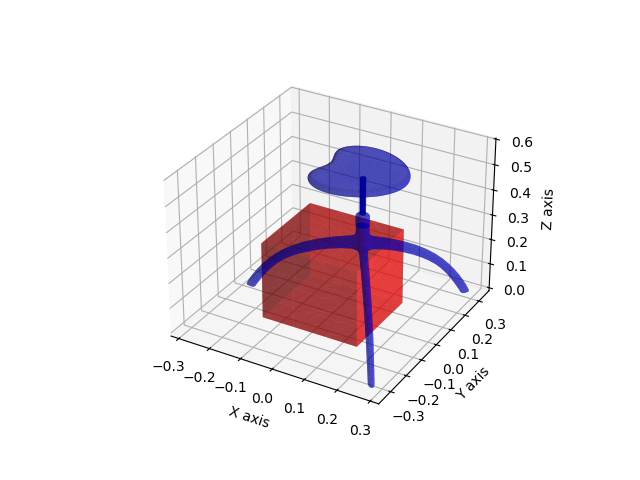

In [15]:
%matplotlib widget
# Plot the two meshes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

mesh1 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/all/07_01_001.obj')
ax.plot_trisurf(mesh1.vertices[:, 0], mesh1.vertices[:,2], mesh1.vertices[:,1], triangles=mesh1.faces, 
                    color='b', alpha=0.5)
 
mesh2 = trimesh.load('/home/hlwang_ipe_genjax/b3d/assets/physion/all_flex_meshes/all/cube.obj')
mesh2.vertices *= 0.3
ax.plot_trisurf(mesh2.vertices[:, 0], mesh2.vertices[:,2], mesh2.vertices[:,1], triangles=mesh2.faces, 
                    color='r', alpha=0.5)

# Set plot limits and labels
# ax.set_xlim(-2, 2)
# ax.set_ylim(-2, 2)
# ax.set_zlim(0, 2)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()

In [16]:
max_distance = maximum_interpenetration_distance(mesh1, mesh2)
print("Maximum Interpenetration Distance:", max_distance)

Maximum Interpenetration Distance: 0.07592218


## memory-efficient implementation

In [23]:
@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    # Implementation remains the same
    epsilon = 1e-6
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = 1.0 / a
    s = p0 - v0
    u = f * jnp.dot(s, h)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    t = f * jnp.dot(e2, q)
    intersects = (~parallel) & (u >= 0.0) & (u <= 1.0) & \
                 (v >= 0.0) & (u + v <= 1.0) & (t > epsilon)
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    intersects = jax.vmap(ray_intersects_triangle, in_axes=(None, None, 0, 0, 0))(
        point, ray_direction, v0, v1, v2)
    num_intersections = jnp.sum(intersects)
    return num_intersections % 2 == 1

def get_inside_mask(mesh_points, other_mesh_vertices, other_mesh_faces):
    point_in_mesh_vmap = jax.vmap(point_in_mesh, in_axes=(0, None, None))
    inside = point_in_mesh_vmap(mesh_points, other_mesh_vertices, other_mesh_faces)
    return inside  # Return boolean mask

# def compute_min_distances(points, mesh_vertices, mesh_faces, batch_size=1024):
#     num_points = points.shape[0]
#     distances = []

#     for i in range(0, num_points, batch_size):
#         batch_points = points[i:i+batch_size]

#         # Compute distances for the current batch
#         batch_distances = compute_min_distances_batch(batch_points, mesh_vertices, mesh_faces)
#         distances.append(batch_distances)

#     # Concatenate distances from all batches
#     distances = jnp.concatenate(distances)
#     return distances

# @jax.jit
# def compute_min_distances_batch(points_batch, mesh_vertices, mesh_faces):
#     v0 = mesh_vertices[mesh_faces[:, 0]]  # (T, 3)
#     v1 = mesh_vertices[mesh_faces[:, 1]]
#     v2 = mesh_vertices[mesh_faces[:, 2]]

#     # Function to compute distances for a single point
#     def point_to_mesh_distance(p):
#         distances = point_triangle_distance(p, v0, v1, v2)  # (T,)
#         min_distance = jnp.min(distances)
#         return min_distance

#     # Vectorize over points in the batch
#     distances = jax.vmap(point_to_mesh_distance)(points_batch)  # (batch_size,)
#     return distances

def compute_min_distances(points, mesh_vertices, mesh_faces):
    v0 = mesh_vertices[mesh_faces[:, 0]]  # (T, 3)
    v1 = mesh_vertices[mesh_faces[:, 1]]
    v2 = mesh_vertices[mesh_faces[:, 2]]

    # Function to compute minimum distance for a single point
    @jax.jit
    def point_to_mesh_distance(p):
        # Use jax.lax.scan to iteratively compute minimum distance
        def body_fun(carry, triangle):
            v0_t, v1_t, v2_t = triangle
            dist = point_triangle_distance(p, v0_t[None, :], v1_t[None, :], v2_t[None, :])[0]
            min_dist = jnp.minimum(carry, dist)
            return min_dist, None

        init = jnp.inf
        triangles = (v0, v1, v2)
        min_distance, _ = jax.lax.scan(body_fun, init, triangles, length=v0.shape[0])
        return min_distance

    # Vectorize over points
    distances = jax.vmap(point_to_mesh_distance)(points)
    return distances

def maximum_interpenetration_distance(mesh1, mesh2, batch_size=1024):
    # Get inside masks
    inside_mask1 = get_inside_mask(mesh1.vertices, mesh2.vertices, mesh2.faces)
    inside_mask2 = get_inside_mask(mesh2.vertices, mesh1.vertices, mesh1.faces)

    # Compute distances in batches
    distances1 = compute_min_distances(mesh1.vertices, mesh2.vertices, mesh2.faces)
    distances2 = compute_min_distances(mesh2.vertices, mesh1.vertices, mesh1.faces)

    # Mask distances for points outside
    distances1 = jnp.where(inside_mask1, distances1, -jnp.inf)
    distances2 = jnp.where(inside_mask2, distances2, -jnp.inf)

    # Compute maximum interpenetration distance
    max_distance1 = jnp.max(distances1)
    max_distance2 = jnp.max(distances2)
    max_interpenetration_distance = jnp.maximum(max_distance1, max_distance2)
    return max_interpenetration_distance

@jax.jit
def point_triangle_distance(p, v0, v1, v2):
    # Compute edges
    ab = v1 - v0  # (T, 3)
    ac = v2 - v0
    ap = p - v0   # p is (3,), broadcasted to (T, 3)

    # Compute normal
    n = jnp.cross(ab, ac)
    n_norm = jnp.linalg.norm(n, axis=1)
    n_norm = jnp.where(n_norm == 0, 1e-8, n_norm)  # Avoid division by zero
    n = n / n_norm[:, None]

    # Distance from point to plane
    dist_to_plane = jnp.abs(jnp.sum(ap * n, axis=1))

    # Project point onto plane
    proj_p = p - dist_to_plane[:, None] * n  # (T, 3)

    # Compute barycentric coordinates
    vp = proj_p - v0
    d00 = jnp.sum(ab * ab, axis=1)
    d01 = jnp.sum(ab * ac, axis=1)
    d11 = jnp.sum(ac * ac, axis=1)
    d20 = jnp.sum(vp * ab, axis=1)
    d21 = jnp.sum(vp * ac, axis=1)
    denom = d00 * d11 - d01 * d01
    denom = jnp.where(denom == 0, 1e-8, denom)  # Avoid division by zero

    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w

    is_inside = (u >= 0) & (v >= 0) & (w >= 0)

    # Closest point
    v_clamped = jnp.clip(v, 0.0, 1.0)
    w_clamped = jnp.clip(w, 0.0, 1.0)
    u_clamped = 1.0 - v_clamped - w_clamped
    closest_point = jnp.where(
        is_inside[:, None],
        proj_p,
        u_clamped[:, None] * v0 + v_clamped[:, None] * v1 + w_clamped[:, None] * v2
    )

    distance = jnp.linalg.norm(p - closest_point, axis=1)
    return distance  # (T,)


In [24]:
max_distance = maximum_interpenetration_distance(mesh1, mesh2)
print("Maximum Interpenetration Distance:", max_distance)

Maximum Interpenetration Distance: 0.07592218


## most memory-efficient distance computation implementation

In [25]:
import jax
import jax.numpy as jnp
from jax import lax

class Mesh:
    def __init__(self, vertices, faces):
        self.vertices = jnp.array(vertices, dtype=jnp.float32)
        self.faces = jnp.array(faces, dtype=jnp.int32)

@jax.jit
def ray_intersects_triangle(p0, d, v0, v1, v2):
    epsilon = 1e-6
    e1 = v1 - v0
    e2 = v2 - v0
    h = jnp.cross(d, e2)
    a = jnp.dot(e1, h)
    parallel = jnp.abs(a) < epsilon
    f = 1.0 / a
    s = p0 - v0
    u = f * jnp.dot(s, h)
    q = jnp.cross(s, e1)
    v = f * jnp.dot(d, q)
    t = f * jnp.dot(e2, q)
    intersects = (~parallel) & (u >= 0.0) & (u <= 1.0) & \
                 (v >= 0.0) & (u + v <= 1.0) & (t > epsilon)
    return intersects

@jax.jit
def point_in_mesh(point, vertices, faces):
    ray_direction = jnp.array([1.0, 0.0, 0.0])
    v0 = vertices[faces[:, 0]]
    v1 = vertices[faces[:, 1]]
    v2 = vertices[faces[:, 2]]
    intersects = jax.vmap(ray_intersects_triangle, in_axes=(None, None, 0, 0, 0))(
        point, ray_direction, v0, v1, v2)
    num_intersections = jnp.sum(intersects)
    return num_intersections % 2 == 1

def get_inside_mask(mesh_points, other_mesh_vertices, other_mesh_faces):
    point_in_mesh_vmap = jax.vmap(point_in_mesh, in_axes=(0, None, None))
    inside = point_in_mesh_vmap(mesh_points, other_mesh_vertices, other_mesh_faces)
    return inside

@jax.jit
def point_triangle_distance(p, v0, v1, v2):
    # Compute edges
    ab = v1 - v0
    ac = v2 - v0
    ap = p - v0

    # Compute normal
    n = jnp.cross(ab, ac)
    n_norm = jnp.linalg.norm(n)
    n_norm = jnp.where(n_norm == 0, 1e-8, n_norm)  # Avoid division by zero
    n = n / n_norm

    # Distance from point to plane
    dist_to_plane = jnp.abs(jnp.dot(ap, n))

    # Project point onto plane
    proj_p = p - dist_to_plane * n

    # Compute barycentric coordinates
    vp = proj_p - v0
    d00 = jnp.dot(ab, ab)
    d01 = jnp.dot(ab, ac)
    d11 = jnp.dot(ac, ac)
    d20 = jnp.dot(vp, ab)
    d21 = jnp.dot(vp, ac)
    denom = d00 * d11 - d01 * d01
    denom = jnp.where(denom == 0, 1e-8, denom)

    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w

    is_inside = (u >= 0) & (v >= 0) & (w >= 0)

    # Closest point
    v_clamped = jnp.clip(v, 0.0, 1.0)
    w_clamped = jnp.clip(w, 0.0, 1.0)
    u_clamped = 1.0 - v_clamped - w_clamped
    closest_point = jnp.where(
        is_inside,
        proj_p,
        u_clamped * v0 + v_clamped * v1 + w_clamped * v2
    )

    distance = jnp.linalg.norm(p - closest_point)
    return distance

@jax.jit
def point_to_mesh_min_distance(p, v0, v1, v2):
    # Function to compute minimum distance over triangles

    def triangle_distance(carry, triangle):
        min_dist = carry
        v0_t, v1_t, v2_t = triangle
        dist = point_triangle_distance(p, v0_t, v1_t, v2_t)
        min_dist = jnp.minimum(min_dist, dist)
        return min_dist, None

    init_min_dist = jnp.inf
    triangles = (v0, v1, v2)

    min_distance, _ = lax.scan(triangle_distance, init_min_dist, triangles, length=v0.shape[0])
    return min_distance

def compute_min_distances(points, mesh_vertices, mesh_faces, point_batch_size=1024, triangle_batch_size=1024):
    num_points = points.shape[0]
    num_triangles = mesh_faces.shape[0]
    distances = []

    for i in range(0, num_points, point_batch_size):
        batch_points = points[i:i+point_batch_size]
        batch_distances = []

        for j in range(0, num_triangles, triangle_batch_size):
            v0 = mesh_vertices[mesh_faces[j:j+triangle_batch_size, 0]]
            v1 = mesh_vertices[mesh_faces[j:j+triangle_batch_size, 1]]
            v2 = mesh_vertices[mesh_faces[j:j+triangle_batch_size, 2]]

            # Vectorized over points in the batch
            def compute_batch(p):
                return point_to_mesh_min_distance(p, v0, v1, v2)

            batch_min_distances = jax.vmap(compute_batch)(batch_points)
            batch_distances.append(batch_min_distances)

        # Stack and minimize over triangle batches
        batch_distances = jnp.stack(batch_distances, axis=1)
        min_distances = jnp.min(batch_distances, axis=1)
        distances.append(min_distances)

    distances = jnp.concatenate(distances)
    return distances

def maximum_interpenetration_distance(mesh1, mesh2, point_batch_size=1024, triangle_batch_size=1024):
    # Get inside masks
    inside_mask1 = get_inside_mask(mesh1.vertices, mesh2.vertices, mesh2.faces)
    inside_mask2 = get_inside_mask(mesh2.vertices, mesh1.vertices, mesh1.faces)

    # Compute distances with batched processing
    distances1 = compute_min_distances(
        mesh1.vertices, mesh2.vertices, mesh2.faces,
        point_batch_size, triangle_batch_size
    )
    distances2 = compute_min_distances(
        mesh2.vertices, mesh1.vertices, mesh1.faces,
        point_batch_size, triangle_batch_size
    )

    # Mask distances for points outside
    distances1 = jnp.where(inside_mask1, distances1, -jnp.inf)
    distances2 = jnp.where(inside_mask2, distances2, -jnp.inf)

    # Compute maximum interpenetration distance
    max_distance1 = jnp.max(distances1)
    max_distance2 = jnp.max(distances2)
    max_interpenetration_distance = jnp.maximum(max_distance1, max_distance2)
    return max_interpenetration_distance


In [26]:
max_distance = maximum_interpenetration_distance(mesh1, mesh2)
print("Maximum Interpenetration Distance:", max_distance)

Maximum Interpenetration Distance: 0.07592218


## non jax version of the code

In [10]:
def max_interpenetration_distance(mesh1, mesh2):
    """
    Calculate the maximum interpenetration distance between two triangulated meshes.
    
    Args:
    mesh1, mesh2: Triangulated mesh objects with vertices and faces
    
    Returns:
    float: Maximum interpenetration distance, or 0 if no contact
    """
    max_distance = 0
    
    # Iterate through vertices of mesh1
    for vertex in mesh1.vertices:
        # Check if the vertex is inside mesh2
        if is_point_inside_mesh(vertex, mesh2):
            # Calculate distance to the closest surface of mesh2
            distance = distance_to_mesh_surface(vertex, mesh2)
            max_distance = max(max_distance, distance)
    
    # Iterate through vertices of mesh2
    for vertex in mesh2.vertices:
        # Check if the vertex is inside mesh1
        if is_point_inside_mesh(vertex, mesh1):
            # Calculate distance to the closest surface of mesh1
            distance = distance_to_mesh_surface(vertex, mesh1)
            max_distance = max(max_distance, distance)
    
    return max_distance

def is_point_inside_mesh(point, mesh):
    """
    Check if a point is inside a mesh using ray casting algorithm.
    """
    # Initialize a counter for intersections
    intersections = 0
    
    # Cast a ray from the point in any fixed direction (e.g., along x-axis)
    ray_direction = jnp.array([1, 0, 0])
    
    # Iterate through all triangles in the mesh
    for face in mesh.faces:
        # Get the vertices of the triangle
        v1, v2, v3 = [mesh.vertices[i] for i in face]
        
        # Check if the ray intersects with the triangle
        if ray_triangle_intersection(point, ray_direction, v1, v2, v3):
            intersections += 1
    
    # If the number of intersections is odd, the point is inside the mesh
    return intersections % 2 == 1

def ray_triangle_intersection(origin, direction, v1, v2, v3):
    """
    Check if a ray intersects with a triangle.
    """
    epsilon = 1e-6
    
    edge1 = v2 - v1
    edge2 = v3 - v1
    h = jnp.cross(direction, edge2)
    a = jnp.dot(edge1, h)
    
    if -epsilon < a < epsilon:
        return False  # Ray is parallel to the triangle
    
    f = 1.0 / a
    s = origin - v1
    u = f * jnp.dot(s, h)
    
    if u < 0.0 or u > 1.0:
        return False
    
    q = jnp.cross(s, edge1)
    v = f * jnp.dot(direction, q)
    
    if v < 0.0 or u + v > 1.0:
        return False
    
    # At this stage, we can compute t to find out where the intersection point is on the line
    t = f * jnp.dot(edge2, q)
    
    if t > epsilon:  # Ray intersection
        return True
    
    return False  # This means that there is a line intersection but not a ray intersection

def distance_to_mesh_surface(point, mesh):
    """
    Calculate the minimum distance from a point to the surface of a mesh.
    """
    min_distance = float('inf')
    
    # Iterate through all triangles in the mesh
    for face in mesh.faces:
        # Get the vertices of the triangle
        v1, v2, v3 = [mesh.vertices[i] for i in face]
        
        # Calculate the distance from the point to the triangle
        dist = point_to_triangle_distance(point, v1, v2, v3)
        
        # Update the minimum distance if necessary
        min_distance = min(min_distance, dist)
    
    return min_distance

def point_to_triangle_distance(point, v1, v2, v3):
    """
    Calculate the minimum distance from a point to a triangle.
    """
    # Calculate the normal of the triangle
    normal = jnp.cross(v2 - v1, v3 - v1)
    normal = normal / jnp.linalg.norm(normal)
    
    # Calculate the distance from the point to the plane of the triangle
    plane_dist = jnp.dot(point - v1, normal)
    
    # Project the point onto the plane of the triangle
    projected_point = point - plane_dist * normal
    
    # Check if the projected point is inside the triangle
    if is_point_inside_triangle(projected_point, v1, v2, v3):
        return abs(plane_dist)
    
    # If not, calculate the minimum distance to the edges of the triangle
    edge_distances = [
        point_to_line_segment_distance(point, v1, v2),
        point_to_line_segment_distance(point, v2, v3),
        point_to_line_segment_distance(point, v3, v1)
    ]
    
    return min(edge_distances)

def is_point_inside_triangle(point, v1, v2, v3):
    """
    Check if a point is inside a triangle using barycentric coordinates.
    """
    # Calculate barycentric coordinates
    v0, v1, v2 = v2 - v1, v3 - v1, point - v1
    d00 = jnp.dot(v0, v0)
    d01 = jnp.dot(v0, v1)
    d11 = jnp.dot(v1, v1)
    d20 = jnp.dot(v2, v0)
    d21 = jnp.dot(v2, v1)
    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1 - v - w
    
    # Check if the point is inside the triangle
    return (0 <= v <= 1) and (0 <= w <= 1) and (u >= 0)

def point_to_line_segment_distance(point, v1, v2):
    """
    Calculate the minimum distance from a point to a line segment.
    """
    segment = v2 - v1
    t = jnp.dot(point - v1, segment) / jnp.dot(segment, segment)
    t = max(0, min(1, t))  # Clamp t to [0, 1]
    projection = v1 + t * segment
    return jnp.linalg.norm(point - projection)

# Example usage
max_distance = max_interpenetration_distance(mesh1, mesh2)
print(f"Maximum interpenetration distance: {max_distance}")


KeyboardInterrupt: 